
##Trabajo final

# Librerias y procesamiento de datos

In [ ]:
import pandas as pd
import math
import numpy as np
from numpy.ma.core import sqrt
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


tf.random.set_seed(345214)

In [ ]:
LOOKBACK = 5 # numero de resagos para predecir (ajuste en la base de datos)
#función para pasar de una serie de tiempo a una tabla con los resagos explícitos

def wrap_data(df, lookback):
  dataset = []
  for index in range(lookback, len(df)+1):
    features = {
        f"col_{i}": float(val) for i, val in enumerate(
          df.iloc[index-lookback:index].values
        )
    }
    row = pd.DataFrame.from_dict([features])
    row.index = [df.index[index-1]]
    dataset.append(row)
  return pd.concat(dataset, axis=0)

In [ ]:
#Importar libreria de yahoo finance
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Vamos a estar trabajando con la serie de tiempo del precio de cierre de la criptomoneda Bitcoin
import yfinance as yf
#traer datos en el inervalo deseado, con periodicidad semanal
BTC = yf.Ticker('BTC-USD')
hist = BTC.history(start="2018-01-01", end="2020-12-21",interval = "1wk")

#pasar datos a una tabla (forma requerida por la red neuronal recurrente)
BTC = wrap_data(hist["Close"], lookback=LOOKBACK) #creacion tabla con rezagos
BTC = BTC.join(hist["Close"].shift(-1)) #añadir la variable en momento t, a la de rezagos
BTC

,col_0,col_1,col_2,col_3,col_4,Close
2018-01-29,16477.599609,13772.000000,11600.099609,11786.299805,8277.009766,8129.970215
2018-02-05,13772.000000,11600.099609,11786.299805,8277.009766,8129.970215,10551.799805
2018-02-12,11600.099609,11786.299805,8277.009766,8129.970215,10551.799805,9664.730469
2018-02-19,11786.299805,8277.009766,8129.970215,10551.799805,9664.730469,11512.599609
2018-02-26,8277.009766,8129.970215,10551.799805,9664.730469,11512.599609,9578.629883
...,...,...,...,...,...,...
2020-11-23,13737.109375,15479.567383,15955.587891,18370.001953,18177.484375,19345.121094
2020-11-30,15479.567383,15955.587891,18370.001953,18177.484375,19345.121094,19142.382812
2020-12-07,15955.587891,18370.001953,18177.484375,19345.121094,19142.382812,23477.294922
2020-12-14,18370.001953,18177.484375,19345.121094,19142.382812,23477.294922,22803.082031


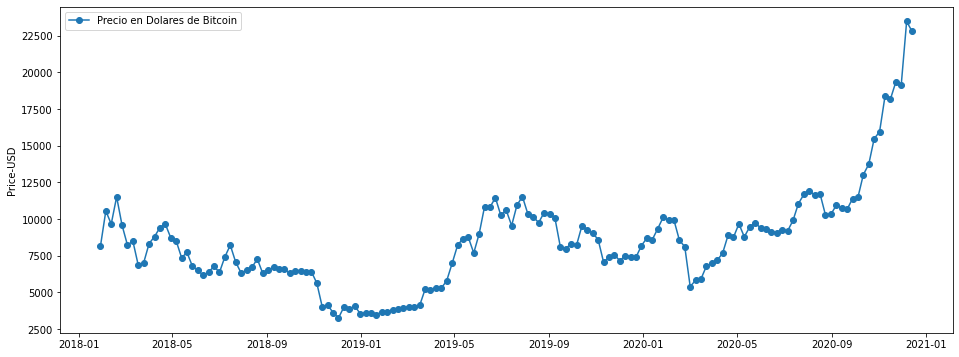

In [ ]:
# Graficamos la serie de tiempo
plt.figure(figsize=(16, 6))
plt.plot(BTC.index, BTC["Close"], 'o-', label="Precio en Dolares de Bitcoin")
plt.ylabel("Price-USD")
plt.legend()

In [ ]:
# particion de la base de datos entre train y test

X_train, X_test, y_train, y_test = train_test_split(
    BTC.drop(columns="Close"),
    BTC["Close"],
    shuffle=False , #es importante mantener la secuencia al tratarse de una serie de tiempo
    test_size=0.1307
)

# Encontrar Hiperparametreos Optimos

In [ ]:
#funcion que a cree un modelo en base a parametros dados
def crear_modelo(neuronas,f_activacion,optimizador):
    input_layer = Input(shape=(LOOKBACK, 1)) #dimenciones de la capa input
    recurrent = Bidirectional(LSTM(neuronas, activation=f_activacion))(input_layer) #establecimiento del numerode neuronas y la funcion de activacion
    output_layer = Dense(1)(recurrent) #capa de salida (recurrente)
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(
        loss='mse', optimizer=optimizador,#seleccion de optimizador
        metrics=[
            keras.metrics.RootMeanSquaredError(),
            keras.metrics.MeanAbsoluteError()
    ])
    return model

#funcion que grafica la comparacion de dos deries
def show_result(y_test, predicted):
  plt.figure(figsize=(16, 6))
  plt.plot(y_test.index, predicted, 'o-', label="predicted")
  plt.plot(y_test.index, y_test, '.-', label="actual")

  plt.ylabel("Price-USD")
  plt.legend()


#funcion para predecir y mostrar resultados
def predecirYgraficar(modelo,X_test,y_test):
  predicted = modelo.predict(X_test)
  show_result(y_test, predicted)
  return predicted

#funcion que obtien la mtrica de comparacion de modelos MSE
def calcular_MSE(y_test,predicted):
  loss =np.mean(np.square(y_test - predicted[:,0]))
  return loss

# funcion que crea y alimenta el modelo , ademas guarda los parametros y el error en un diccionario
def model_evaluation(X_train, X_test, y_train, y_test,numero_neuronas,
                     funcion_activacion,optimizador):
  LSTM_Model=crear_modelo(neuronas=numero_neuronas,f_activacion=funcion_activacion,
                          optimizador=optimizador)
  LSTM_Model.fit(X_train, y_train, epochs=500, callbacks=[callback])

  prediccion= predecirYgraficar(LSTM_Model,X_test,y_test)

  loss=calcular_MSE(y_test,prediccion)

  parametros={"numero_neuronas":numero_neuronas,
              "funcion_activacion":funcion_activacion,
              "optimizador":optimizador,
              "loss":loss,
              "prediccion":prediccion}
  return parametros




Se han truncado las últimas 5000 líneas del flujo de salida.
5/5 [==============================] - 0s 10ms/step - loss: 62791732.0000 - root_mean_squared_error: 7924.1235 - mean_absolute_error: 7614.1748
Epoch 155/500
5/5 [==============================] - 0s 7ms/step - loss: 62790952.0000 - root_mean_squared_error: 7924.0742 - mean_absolute_error: 7614.1245
Epoch 156/500
5/5 [==============================] - 0s 7ms/step - loss: 62790184.0000 - root_mean_squared_error: 7924.0259 - mean_absolute_error: 7614.0737
Epoch 157/500
5/5 [==============================] - 0s 7ms/step - loss: 62789404.0000 - root_mean_squared_error: 7923.9766 - mean_absolute_error: 7614.0225
Epoch 158/500
5/5 [==============================] - 0s 7ms/step - loss: 62788628.0000 - root_mean_squared_error: 7923.9277 - mean_absolute_error: 7613.9722
Epoch 159/500
5/5 [==============================] - 0s 8ms/step - loss: 62787852.0000 - root_mean_squared_error: 7923.8784 - mean_absolute_error: 7613.9204
Epoch 160/

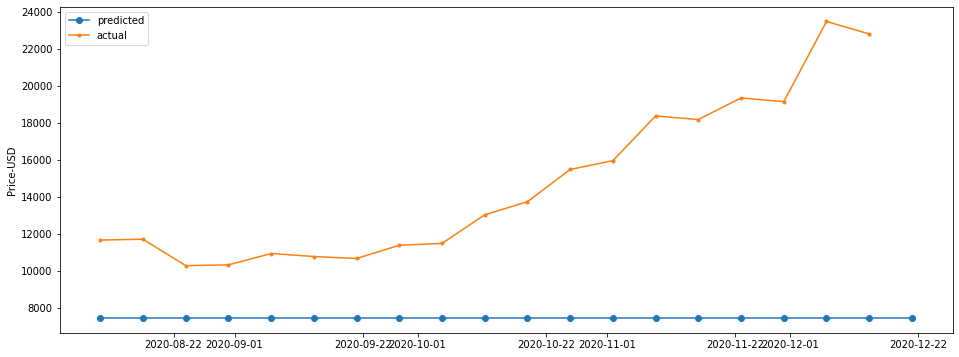

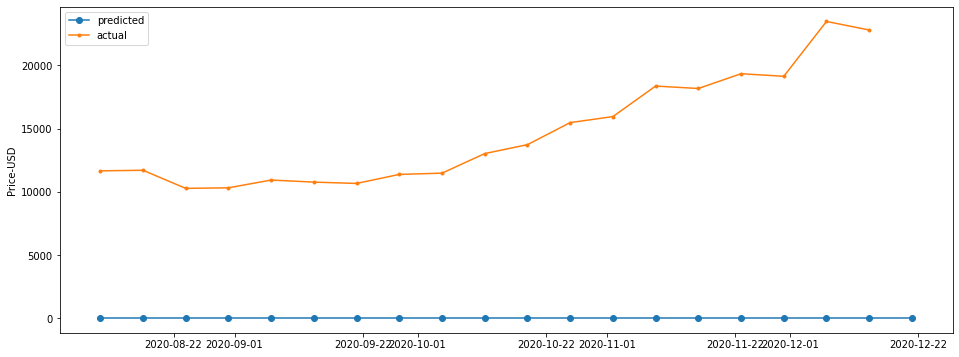

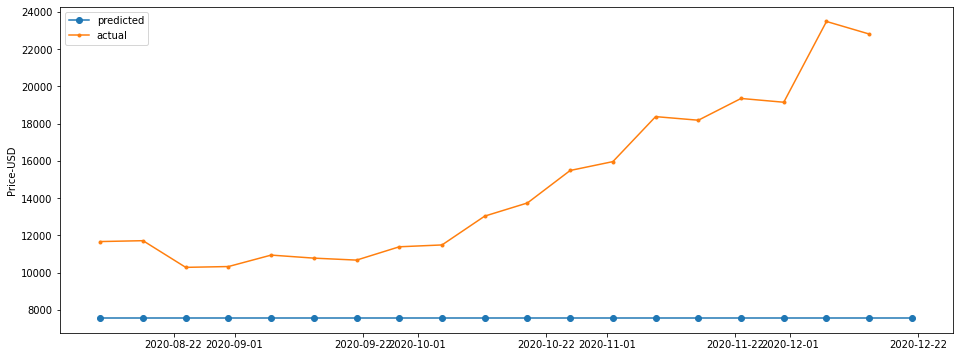

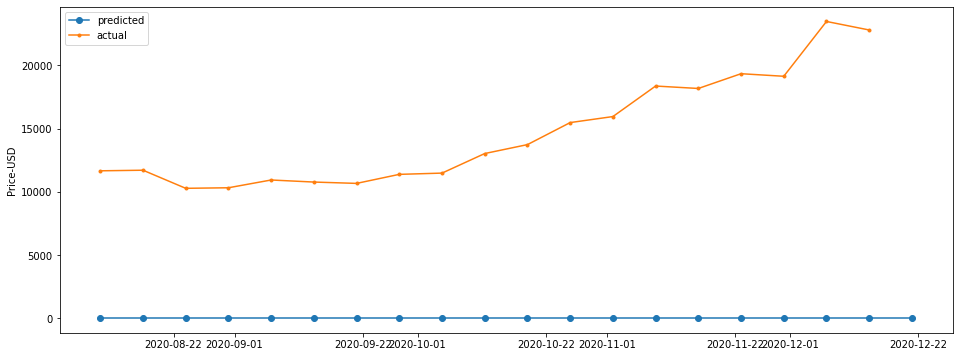

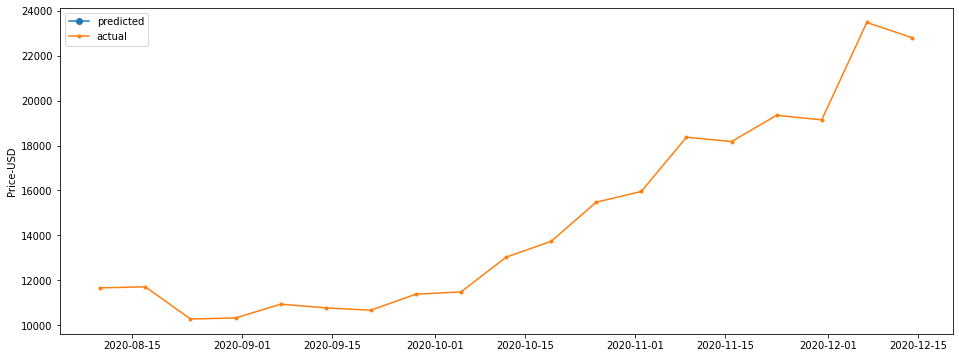

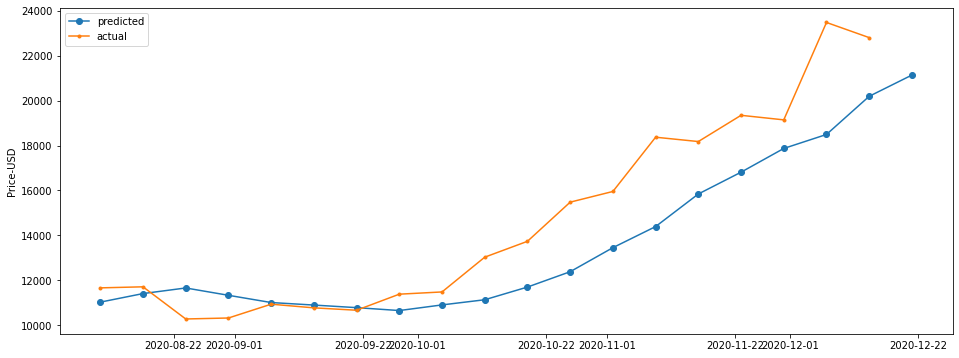

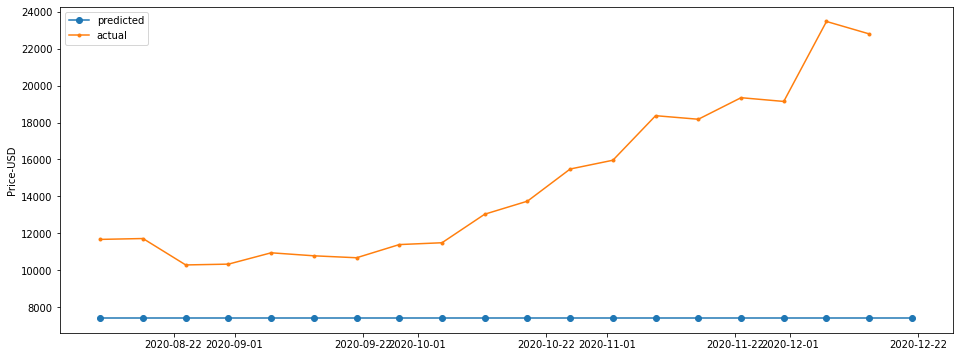

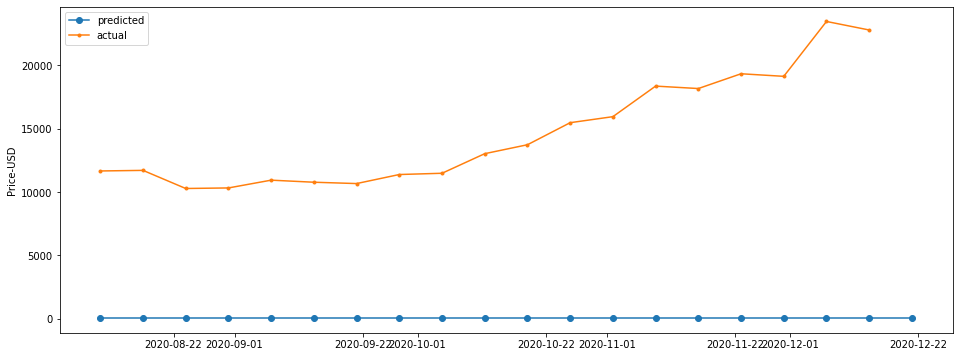

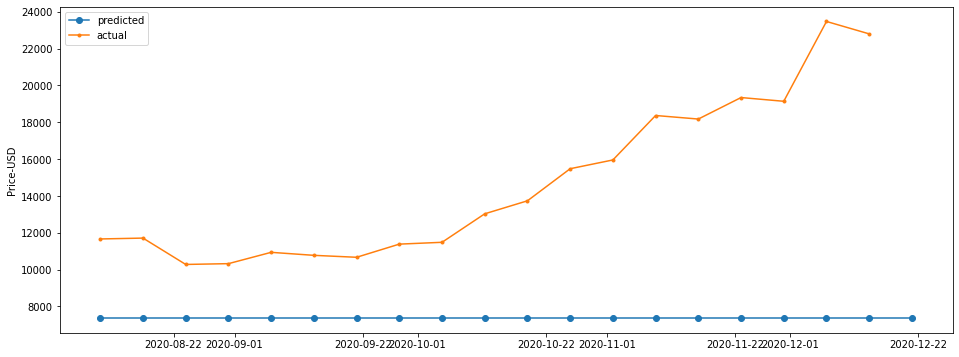

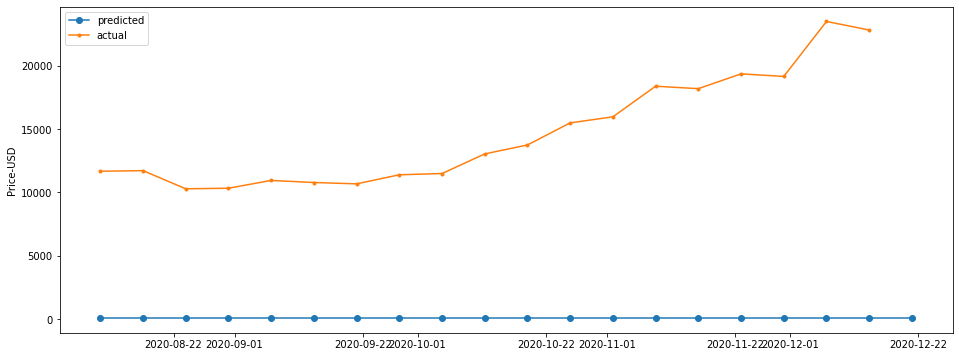

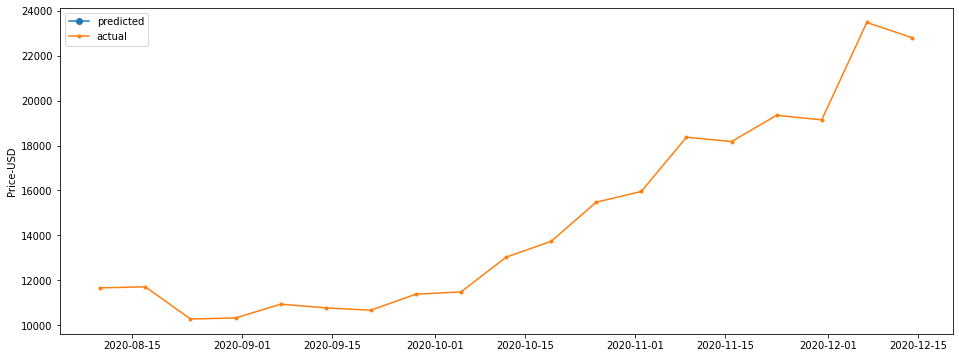

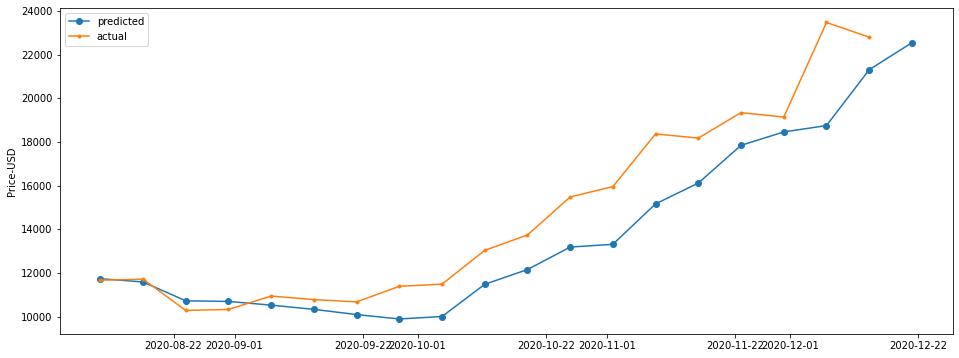

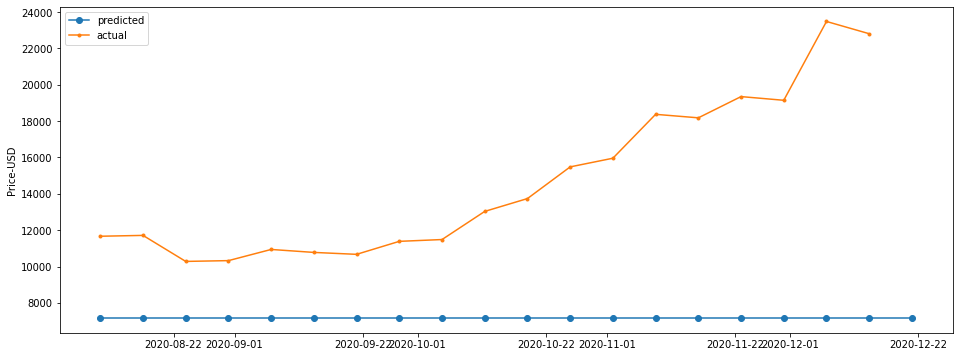

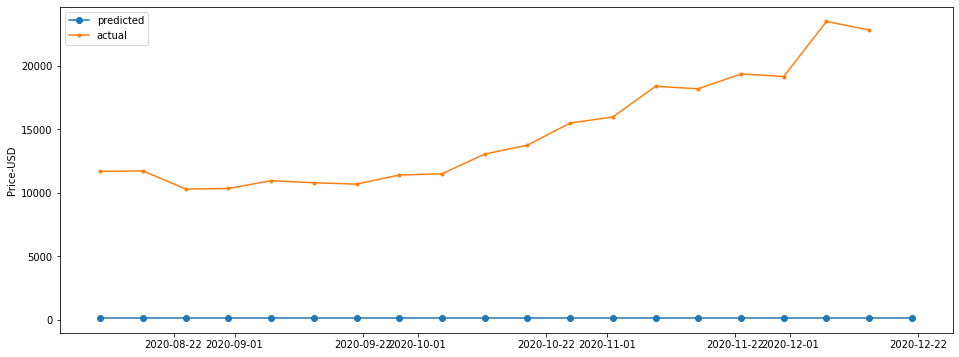

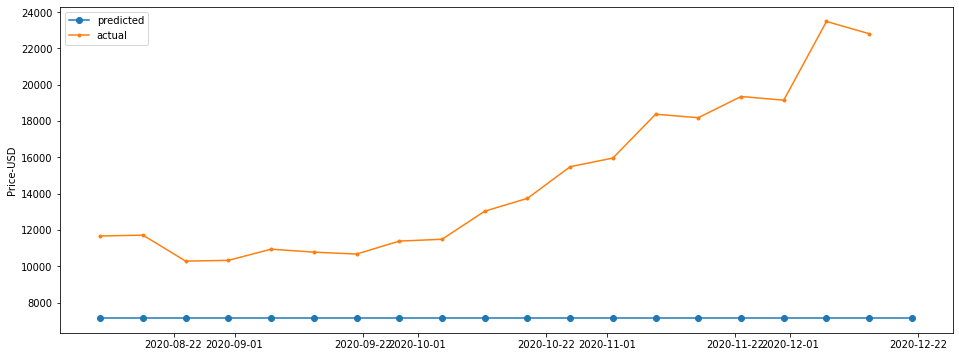

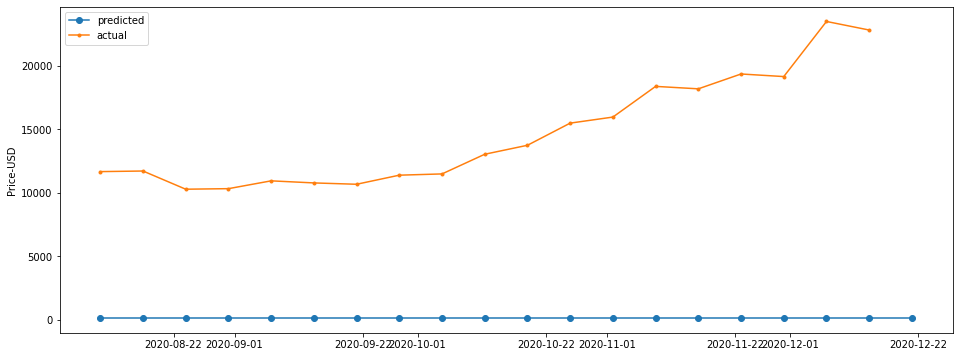

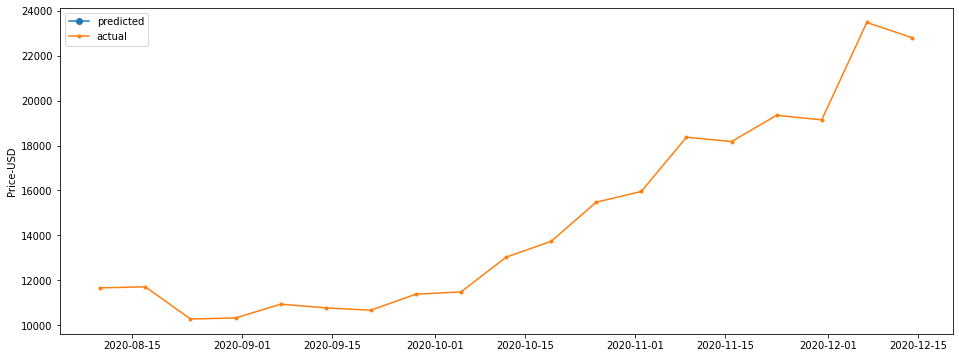

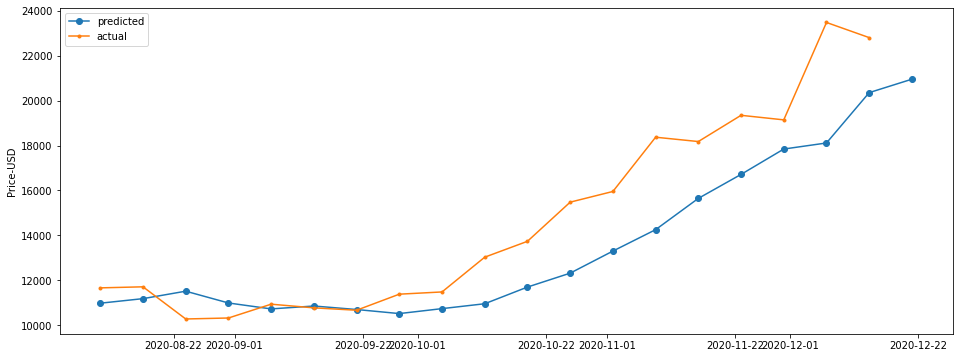

In [ ]:
#creamos una lista de posibles hiperparametros
lista_neuronas=[20,50,100]
lista_F_activacion=["tanh","sigmoid","relu"]
lista_optimizadores=["sgd","adam"]

#el callback es para detener el entrnamiento dado el comportamiento de loss
#esto es para evitar sobreajuste o sub ajuste
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

#recorremos todas las posibles conbinaciones de hiperparametros y nos quedamos con
#la informacion de los hiperparametros que minimizan el error
optimo= math.inf
for i in lista_neuronas:
  for j in lista_F_activacion:
    for k in lista_optimizadores:
      Comportamiento_parametros=model_evaluation(X_train=X_train, X_test=X_test, y_train=y_train,
                                y_test=y_test,numero_neuronas=i,
                                 funcion_activacion=j , optimizador=k)

      if Comportamiento_parametros["loss"] < optimo:
        optimo=Comportamiento_parametros["loss"]
        Big_P=Comportamiento_parametros

Los mejores parametros para el modelo son : numero_neuronas = 50 ,funcion_activacion= relu ,
 optimizador= adam ,Tiene un MSE = 3394711.4720898177 y un MSE parcial de  611360.3370871014


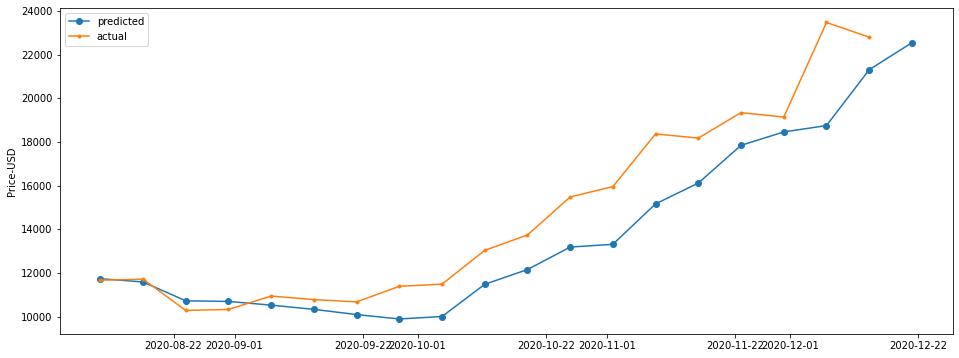

In [ ]:
  # escribimos y graficamos los resultados de la red neuronal
  print("Los mejores parametros para el modelo son : numero_neuronas =",Big_P["numero_neuronas"],
        ",funcion_activacion=",Big_P["funcion_activacion"],
        ",\n optimizador=",Big_P["optimizador"],
        ",Tiene un MSE =",Big_P["loss"],
        "y un MSE parcial de ", calcular_MSE(y_test[0:9],Big_P["prediccion"][0:9]))

show_result(y_test, Big_P["prediccion"])

la razon entres el error del modelo var y el modelo RNN es : 9.972170029272027 
, por otra parte la misma relacion pero con los primeros datos es de  0.27833339796094225


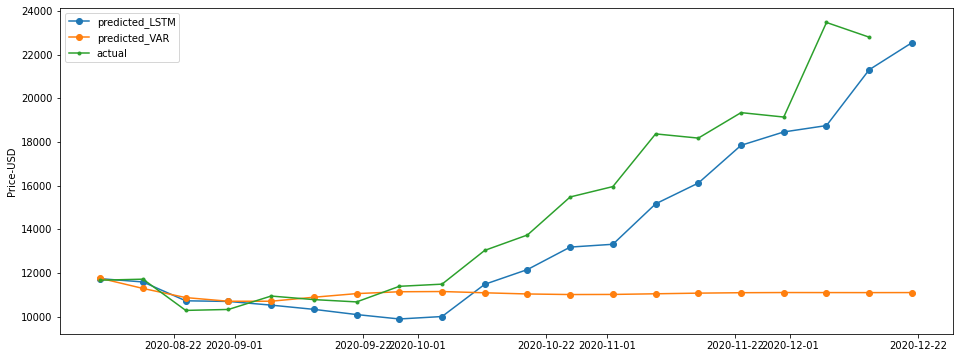

In [ ]:
# del script de R traemos las predicciones para el mismo intervalo de tiempo, asi como su error cuadrático medio
prediccion_VAR=[11753.01, 11286.26 ,10867.72, 10699.45, 10701.04,
 10883.98 ,11049.81 ,11134.89 ,11145.10 ,11087.38,
 11033.24 ,11007.35 ,11011.89 ,11041.78 ,11071.33,
 11091.10 ,11098.82 ,11097.22 ,11095.47 ,11097.35]

#Graficamos los datos de testeo y las dos predicciones de los dos modelos distintos
plt.figure(figsize=(16, 6))
plt.plot(y_test.index, Big_P["prediccion"], 'o-', label="predicted_LSTM")
plt.plot(y_test.index, prediccion_VAR, 'o-', label="predicted_VAR")
plt.plot(y_test.index, y_test, '.-', label="actual")
plt.ylabel("Price-USD")
plt.legend()

#comparacion de errores
#toda la prediccion
MSE_VAR=33852640
Indicador_total=MSE_VAR/Big_P["loss"]

#las primera 10 observaciones
MSE_VAR_parcial=170162
Indicador_parcial=MSE_VAR_parcial/calcular_MSE(y_test[0:9],Big_P["prediccion"][0:9])

print("la razon entre el error del modelo var y el modelo RNN es:",
      Indicador_total,
      "\n, por otra parte la misma relacion pero con los primeros datos es de",
      Indicador_parcial)

Referencias:

Auffarth, B. (2021). Machine Learning for Time-Series with Python: Forecast, predict, and detect anomalies with state-of-the-art machine learning methods. Packt Publishing.

Lazzeri, F. (2021). Machine learning for time series forecasting with python. John Wiley Sons.